In [56]:
"""
*** Functions for NGS pointing sequence ***
"""

import numpy as np

# Normalize RA values to the range [-180, 180] degrees.
def normalize_ra(ra):
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra

# find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

# Determine the index of the best starting point of the next bin
# by finding the closest point to the last point of the previous bin
def StartingPoint(last_point, current_bin):
    min_distance = float('inf')
    for i, current_point in enumerate(current_bin):
        angular_distance = Haversine(last_point, current_point)
        if angular_distance < min_distance:
            min_distance = angular_distance
            start_index = i # store the index of the best starting point
    return start_index

import itertools
# Given a sample of points, determine the optimal path (min. distance) to connect all points
def find_path(points, start_point=None):
    # Generate all possible permutations of the points, excluding the last point
    point_permutations = itertools.permutations(points[:-1])
    
    # Keep track of the minimum distance and the corresponding path
    min_distance = float('inf')
    min_path = None
    
    # Iterate through all permutations and calculate total distance for each
    for path in point_permutations:
        # Add the first and last point to the list of points
        if start_point is None:
            full_path = path + (points[-1],)
        else:
            full_path = (start_point,) + path + (points[-1],)
        
        total_distance = 0
        for i in range(len(full_path) - 1):
            p1, p2 = full_path[i], full_path[i+1]
            total_distance += Haversine(p1, p2)

        # Check if the current path has a shorter total distance
        if total_distance < min_distance:
            min_distance = total_distance
            min_path = full_path

    return min_path, min_distance

### Selecting k number of points in a sample

In [44]:
import random

# NGS is a list of total candidate points
NGS = np.genfromtxt('NGS_sample.csv', delimiter=',', skip_header=1, usecols=(0,1))
NGS[:,0] = np.vectorize(normalize_ra)(NGS[:,0])

# Select a sample of k number of points
k = 50
sample = random.sample(list(NGS), k)
len(sample)

50

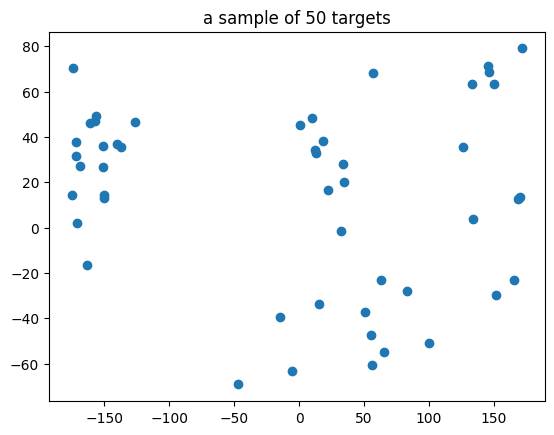

In [45]:
import matplotlib.pyplot as plt
x, y = zip(*sample)
plt.scatter(x, y)
plt.title(f'a sample of {len(sample)} targets')
plt.show()

#### (1) bin by number of points

In [47]:
# Group every n points into a bin
""" Pick how many points in each bin """
n = 10
bins = [sortNGS[i:i+n] for i in range(0, len(sortNGS), n)]
print(f'{len(bins)} bins')

5 bins


In [48]:
pointing_sequence = []

# Iterate through the bins
for index, points in enumerate(bins):
    if index == 0:
        # For the first bin
        min_path, min_distance = find_path(points)
        last_point = min_path[-1]
    else:
        # For the rest of the bins
        start_index = StartingPoint(last_point, points)
        start_point = points.pop(start_index)  # pop the starting point out of the bin
        min_path, min_distance = find_path(points, start_point)
        last_point = min_path[-1]
    
    print(f'Bin {index+1}:')
    print(f"Minimum angular distance: {min_distance}")
    print("Optimal path:", min_path)
    print()

    # Store the optimal path of each bin
    pointing_sequence.append(min_path)

Bin 1:
Minimum angular distance: 72.05955940201368
Optimal path: (array([-164.18      ,  -17.42305556]), array([-171.38722229,    2.18824291]), array([-170.74066667,    6.92525   ]), array([-174.27113342,   15.82230377]), array([-173.25416667,   23.90416667]), array([-168.67854167,   27.12548889]), array([-166.47833333,   27.14861111]), array([-170.65966667,   38.74116667]), array([-171.4975    ,   39.01944444]), array([-161.94958333,   44.03888889]))

Bin 2:
Minimum angular distance: 266.6063288224195
Optimal path: (array([-161.38375   ,   45.91916667]), array([-161.12375   ,   47.49888889]), array([-157.50541667,   47.26805556]), array([-157.98541667,   33.55583333]), array([-158.222625  ,  -27.95636667]), array([-146.70875549,  -65.33914948]), array([-138.94870833,   42.62788889]), array([-143.81916667,   44.52583333]), array([-148.61208333,   54.46083333]), array([-99.94833333,  57.91527778]))

Bin 3:
Minimum angular distance: 268.6019420755843
Optimal path: (array([ 9.14541667, 49

For 10 points in each bin
Total angular distance traveled: 1156.2116319937827°


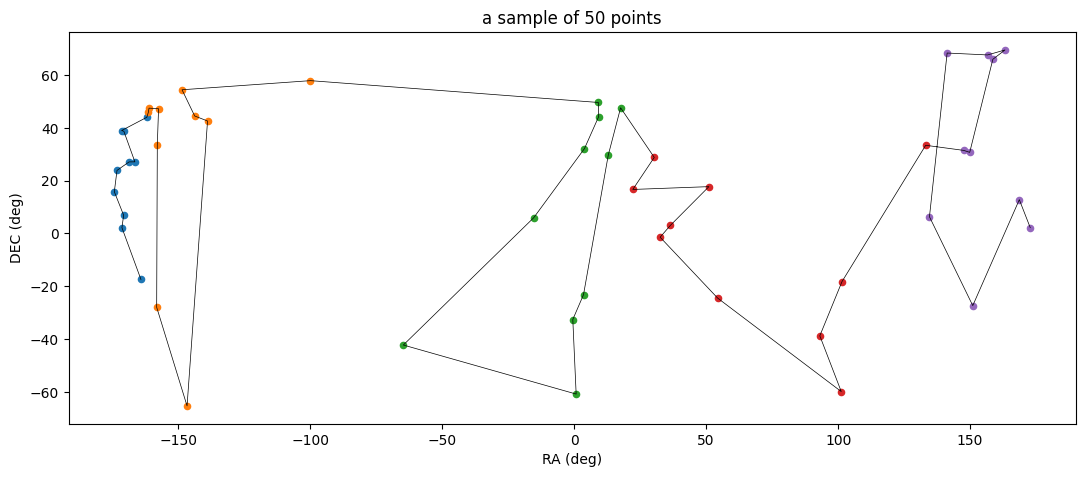

In [55]:
path = [point for bin_path in pointing_sequence for point in bin_path]
total_dist = 0
for i in range(len(path)-1):
    p1, p2 = path[i], path[i+1]
    total_dist += Haversine(p1, p2)

print(f'For {n} points in each bin')
print(f'Total angular distance traveled: {total_dist}°')

fig, ax = plt.subplots(1,1,figsize=(13,10))
ax.set_aspect('equal')
px, py = zip(*path)
plt.plot(px, py, linewidth=0.5, color='k')

for bin_path in pointing_sequence:
    x, y = zip(*bin_path)
    plt.scatter(x, y, s=20)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title(f'a sample of {len(path)} points')
# plt.title(f'{n} points in each bin, {int(total_dist)}° total angular distance traveled')
plt.show()

In [61]:
"""
*** Functions for tracking time and calculating observing efficiency ***
"""
import math 

def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time

def Seconds2Day(time):
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    return day, hour, minutes, seconds

# Convert time elapsed in an orbit (sec.) --> telescope's position (degrees) in an orbit around the Earth
# Angle theta starts in the East (viewed facing sun) going CCW; always between 0° to 360°
def Position(orbitTimeTrack):
    period = 100.9 # min
    # orbitTimeTrack is time elapsed from startAngle 
    theta = (orbitTimeTrack/60/period)*360 # degrees
    return theta

# the time passed (in sec.) while the telescope moves a given angle in the orbit
def PassedTime(angle):
    period = 100.9 # min
    return (angle/360)*period*60
    
# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

# With theta = 0° at positive RA (x-axis) direciton, (i.e. starts in the East viewed facing sun) going CCW
# satellite position = (x0, y0) where y0 = -7.8
# target = coords (x, y)
def ViewingZone(x0, target):
    y0 = -7.8
    x, y = target[0], target[1]
    xp = x - x0
    yp = y - y0
    # the direction where the boresight is pointing 
    theta = math.degrees(math.atan2(yp, xp))
    theta = (theta + 360) % 360
    # the angular distance the pointing is away from CVZ
    theta_b = math.sqrt(xp**2 + yp**2)
    #print('angle away from CVZ center:', theta_b)
    frac = ViewingFrac(theta_b)
    #print('viewing efficiency:', frac)
    halfVisAngle = frac*180 # degrees
    zone = [(theta-halfVisAngle+360)%360, (theta+halfVisAngle+360)%360]
    return zone

# Determine the types of viewing zone
def ZoneType(index, startzone, endzone):
    # three types of viewing zone
    if endzone-startzone > 10**-5:
        # the viewing zone is continuous, where startzone < endzone
        type = 1
        print(f"\033[1mtarget {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    elif round(startzone,5) == round(endzone,5):
        # the target is in CVZ
        type = 2
        print(f"\033[1mtarget {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    else:
        # the viewing zone wraps around from 360° to 0° 
        type = 3
        print(f"\033[1mtarget {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
    return type

def AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime):
    if startzone > theta:
        dead_time = PassedTime(startzone-theta+0.0001)
    else:
        dead_time = PassedTime(360-theta+startzone+0.0001)
    place_holder.append([dead_time, [theta, startzone+0.0001]])
    ElapsedTime += dead_time
    dayTimeTrack += dead_time
    orbitTimeTrack += dead_time
    dataTimeTrack += dead_time
    DeadTime += dead_time
    print('Dead time:', round(dead_time,2), 's')
    print()
    return place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime

# Calculate how much time is available in the current viewing cycle
def TimeAvailable(type, endzone, theta): 
    if type==1:
        time_available = PassedTime(endzone-theta)
    elif type==2:
        time_available = PassedTime(360) # if the target is in CVZ, there is infinite time available
    else:
        if endzone > theta:
            time_available = PassedTime(endzone-theta)
        else:
            time_available = PassedTime(360-theta+endzone)
    return time_available

# Update the time spend on moving to the target and imaging
# need to specify which of the actions(slew, settle, and exposure) are included in this update
def Update4Imaging(slew, settle, Exposure, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack):
    overhead_time += slew + settle
    exposure_time += Exposure
    ElapsedTime += Exposure + slew + settle
    dayTimeTrack += Exposure + slew + settle
    orbitTimeTrack += Exposure + slew + settle
    dataTimeTrack += Exposure + slew + settle
    return overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack

""" Time Trackers in the WideObserving code """
# Track Data
def TrackData(overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data):
    # Data Info
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/4
    downlink_rate = 10/8 # GBps
    # max downlink window
    downlink_window = 5*60 # seconds
    downlink_max = downlink_rate * downlink_window # GB
    datacap = 440 # GB
    
    if dataTimeTrack >= 12*3600:
        data_capacity = round((onboard_data/datacap)*100, 1)
        # data >= 375 GB
        if onboard_data >= downlink_max:
            #print(f'<< Downlinking Data takes {downlink_window/60 + 1} min. >>')
            #print()
            overhead_time += downlink_window + 1*60
            ElapsedTime += downlink_window + 1*60
            dayTimeTrack += downlink_window + 1*60
            downlinked_data += downlink_max
            onboard_data -= downlink_max
        # data < 375 GB
        else:
            #print(f'<< Downlinking Data takes {(onboard_data/downlink_rate)/60 + 1} min. >>')
            #print()
            overhead_time += (onboard_data/downlink_rate) + 1*60
            ElapsedTime += (onboard_data/downlink_rate) + 1*60
            dayTimeTrack += (onboard_data/downlink_rate) + 1*60
            downlinked_data += onboard_data
            onboard_data = 0
        dataTimeTrack = 0 
    return overhead_time, ElapsedTime, dataTimeTrack, dayTimeTrack, downlinked_data, onboard_data

# Track Orbit around Earth
def TrackOrbit(orbitTimeTrack, orbit_num):
    period = 100.9 # min
    # onto the the next orbit
    if orbitTimeTrack >= period*60:
        orbit_num += 1
        #print(f'{round(orbitTimeTrack/60,2)} min. passed --> entering new orbit')
        #print()
        orbitTimeTrack -= period*60
    return orbitTimeTrack, orbit_num

# Track Day: update satellite position across RA every day
def TrackDay(dayTimeTrack, day_num, sat_position, target):
    daily_step = 360/365 # CVZ center movement across RA per day
    if dayTimeTrack >= 24*60*60:
        day_num += 1
        sat_position += daily_step
        print()
        print(f'\033[1m{round(dayTimeTrack/60/60,2)} hrs passed --> a new day\033[0m')
        print(f"\033[1msatellite's RA = {sat_position}°\033[0m")
        print(f'\033[1mviewing target on RA ~ {target[0]}°\033[0m')
        print()
        dayTimeTrack = 0
    return dayTimeTrack, day_num, sat_position



In [72]:
""" Half of the NGS sample has exposure = 2100s = 35min. (complete in one orbit)
    The other half has double the exposure (complete in two orbits) """

def NGObserving(pointing_sequence, days_ahead, startAngle, exposure, settle=90):

    # flatten the pointing_sequence array
    path = [point for bin_path in pointing_sequence for point in bin_path]
    
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    
    # all time are in seconds if not specified
    """ Time Tracker """
    dayTimeTrack = 0
    orbitTimeTrack = 0
    dataTimeTrack = 0 
    DeadTime = 0
    ElapsedTime = 0
    
    """ Info Tracker """
    overhead_time = 0
    exposure_time = 0
    onboard_data = 0 # GB
    downlinked_data = 0 # GB
    orbit_num = 0
    day_num = 0

    index = 0
    slew_distance = 0
    # gap = [time_gap, RA_gap]
    gap = [] # catalog the time and range the telescope is not surveying nearby galaxy targets
    target_num = len(path)
    all_targets = path # create another one to pop the targets from 
    depth = 0 # counting the exposure depth
    
    # start the satellite's RA position "days_ahead" the first target in the pointing sequence
    daily_step = 360/365 # CVZ center movement across RA per day
    sat_position = path[0][0] - days_ahead*daily_step
    start_sat = sat_position
    print(f"satellite's starting RA = {start_sat}°")
    
    """ BEGIN OBSERVING HERE: going through all the points """

    while all_targets:
        index += 1
        target = all_targets.pop(0)
        print("target's position =", target)

        # Check the satellite's position
        if abs(sat_position-
    
        # Update telescope position
        theta = (Position(orbitTimeTrack) + startAngle) % 360
        print(f'telescope position around Earth = {round(theta,4)}°')

        # Find the target's viewing zone based on the satellite RA position 
        zone = ViewingZone(sat_position, target)
        startzone, endzone = zone[0], zone[1]
        type = ZoneType(index, startzone, endzone)

        # If the telescope is NOT in the target's viewing zone, WAIT until it is in the zone
        if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            print(f'telescope position around Earth = {round(theta,4)}°')
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, target)

        # Complete imaging once the telescope is in the viewing zone
        # But first, check if there's enough time left to complete the full exposure time
        time_available = TimeAvailable(type, endzone, theta)
        time_used = 0
        if index != 1:
            angle = Haversine(path[index-2], target)
            print('slew angular distance:', angle)
            slew_distance += angle
            slew = Angle2Time(angle)
            time_used = slew + settle
        time_left = time_available - time_used

        # Add deadtime if there is not enough time in the current orbit
        if time_left < exposure:
            print(f'time available for imaging in this orbit: {round(time_left,4)}s, NOT enough time')
            """ Add dead time """
            place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
            # Update telescope position
            theta = (Position(orbitTimeTrack) + startAngle) % 360
            print(f'telescope position around Earth = {round(theta,4)}°')

        # Slew to the target
        if index != 1:
            print('slew + settle takes', slew + settle, 's')
            """ Update Time - slewing to the target """
            overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack)

        # Image the target
        time_available = TimeAvailable(type, endzone, theta)
        time_left = time_available - time_used
        print(f'time available for imaging in this orbit: {round(time_left,4)}s, enough time to fully image')
        onboard_data += data
        print('\033[1mCompleted exposure =\033[0m', exposure, 's')
        """ Update Time - imaging """
        overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, exposure, overhead_time, exposure_time, ElapsedTime, dayTimeTrack, orbitTimeTrack, dataTimeTrack)
        print()
        
        """ Track Orbit """
        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
        """ Track Day """
        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position, target)

        # only half of the targets need an exposure depth of two orbits
        if index > target_num//2:
            depth += 1
            if depth == 1:
                # has only imaged for an orbit, need to image the same target again for another orbit
                all_targets = [target] + all_targets
                index -= 1
            else:
                # already imaged twice, can move on to the next target
                continue
    
    # When all tiles are completed
    end_sat = sat_position
    sat_range = (start_sat, end_sat) # the RA range that the satellite moved while completing the survey
    print(f'satellite covered an RA range of {round(start_sat,2)}° - {round(end_sat,2)}°')
    print(f'{index} tiles successfully imaged')
    print('currently on orbit', orbit_num+1, 'around Earth')
    print()
    
    print(f'* exposure time: {exposure_time}s = {round(exposure_time/3600,2)} hrs')  
    print(f'* overheads (slew + settle + downlink data): {round(overhead_time/3600,2)} hrs')
    print(f'\033[1m* Total dead time: {round(DeadTime/3600,2)} hrs\033[0m')
    print('\033[1mTotal Elapsed Time = exposure + overheads + deadtime\033[0m')
    time = Seconds2Day(ElapsedTime)
    print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec \033[0m')
    Efficiency = (exposure_time / ElapsedTime)*100
    MaxEfficiency = (exposure_time + DeadTime/3) / ElapsedTime * 100
    print(f'\033[1mObserving Efficiency: {round(Efficiency,2)}%\033[0m')
    print('Assume we can \033[1mrecover one third of the deadtime\033[0m')
    print(f'the observing efficiency is: \033[1m{round(MaxEfficiency,2)}%\033[0m')
    print()
    print(f'Data onboard: {round(onboard_data,2)} GB')
    print(f'Data downlinked: {round(downlinked_data,2)} GB')
    
    return sat_range, place_holder, Efficiency

In [73]:
days_ahead = 0
startAngle = 0
exposure = 2100
sat_range, place_holder, Efficiency = NGObserving(pointing_sequence, days_ahead, startAngle, exposure, settle=90)

satellite's starting RA = -161.38375°
target's position = [-161.38375      45.91916667]
telescope position around Earth = 0.0°
target 1's viewing zone: [338.3416°, 360°] [0°, 201.6584°] 
time available for imaging in this orbit: 3391.2215s, enough time to fully image
Completed exposure = 2100 s

target's position = [-161.12375      47.49888889]
telescope position around Earth = 124.8761°
target 2's viewing zone: [338.5147°, 360°] [0°, 200.9465°] 
slew angular distance: 2.460554628975858
time available for imaging in this orbit: 1117.7237s, NOT enough time
Dead time: 3592.69 s

telescope position around Earth = 338.5148°
slew + settle takes 161.5266555477103 s
time available for imaging in this orbit: 3579.0328s, enough time to fully image
Completed exposure = 2100 s

target's position = [-157.50541667   47.26805556]
telescope position around Earth = 112.9961°
target 3's viewing zone: [334.7299°, 360°] [0°, 197.2129°] 
slew angular distance: 75.22720474282825
time available for imaging 

ValueError: math domain error

#### (2) bin by RA range

In [41]:
# Sort the points in the sample by smallest to largest RA value
sortNGS = sorted(sample, key=lambda point: point[0])
print(f'Selected a sample size of {len(sortNGS)} points')
minRA, maxRA = sortNGS[0][0], sortNGS[-1][0]
print(f'with RA values ranging from {minRA}° to {maxRA}°')

# Creat bins with a range of 'RA_range'
RA_range = 30
print(f'RA range: {RA_range}°')
bins = [[] for _ in range(int((maxRA - minRA) // RA_range) + 1)]
print(f'there will be {len(bins)} bins with increments of {RA_range}° RA')

for point in sortNGS:
    RAvalue = point[0]
    bin_index = int((RAvalue - minRA) // RA_range)
    bins[bin_index].append(point)
for i, points in enumerate(bins):
    print(f'bin {i+1}: {len(points)} points')

Selected a sample size of 50 points
with RA values ranging from -174.27113342285156° to 172.79000000000002°
RA range: 30°
there will be 12 bins with increments of 30° RA
bin 1: 17 points
bin 2: 2 points
bin 3: 1 points
bin 4: 1 points
bin 5: 0 points
bin 6: 5 points
bin 7: 7 points
bin 8: 3 points
bin 9: 1 points
bin 10: 2 points
bin 11: 6 points
bin 12: 5 points


In [43]:
pointing_sequence = []

# Iterate through the bins
for index, points in enumerate(bins):

    if len(points) == 0:
        continue
    elif 1 <= len(points) <= 3:
        min_path = points
    else:
        if index == 0:
            # For the first bin
            min_path, min_distance = find_path(points)
            last_point = min_path[-1] # note down the last point of this bin
        else:
            # For the rest of the bins
            start_index = StartingPoint(last_point, points)
            start_point = points.pop(start_index)  # pop the starting point out of the bin
            min_path, min_distance = find_path(points, start_point)
            last_point = min_path[-1] # note down the last point of this bin

    # Store the optimal path of each bin
    pointing_sequence.append(min_path)
    
    print(f'Bin {index+1}:')
    print("Optimal path:", min_path)
    print()

KeyboardInterrupt: 

### Using all points in the sample

In [35]:
# Given a list of random targets (points)
NGS = np.genfromtxt('NGS_sample.csv', delimiter=',', skip_header=1, usecols=(0,1))
NGS[:,0] = np.vectorize(normalize_ra)(NGS[:,0])

# Sort the points by smallest to largest RA value
sortNGS = sorted(NGS, key=lambda point: point[0])

print(len(sortNGS))

# Group every n points into a bin
""" Pick how many points in each bin """
n = 10
bins = [sortNGS[i:i+n] for i in range(0, len(sortNGS), n)]
len(bins)

563


57

In [36]:

pointing_sequence = []

# Iterate through the bins
for index, points in enumerate(bins):
    if index == 0:
        # For the first bin
        min_path, min_distance = find_path(points)
        last_point = min_path[-1]
    else:
        # For the rest of the bins
        start_index = StartingPoint(last_point, points)
        start_point = points.pop(start_index)  # pop the starting point out of the bin
        min_path, min_distance = find_path(points, start_point)
        last_point = min_path[-1]
    
    print(f'Bin {index+1}:')
    print(f"Minimum angular distance: {min_distance}")
    print("Optimal path:", min_path)
    print()

    # Store the optimal path of each bin
    pointing_sequence.append(min_path)

Bin 1:
Minimum angular distance: 93.94612731098164
Optimal path: (array([-178.99666667,   52.58833333]), array([-178.49583333,   47.47777778]), array([-177.50666667,   46.4575    ]), array([-176.56375   ,   36.63416667]), array([-176.96208333,   36.16916667]), array([-178.78416667,   26.9925    ]), array([-177.91546667,   13.68418889]), array([-179.96208333,    0.681     ]), array([-1.76938767e+02,  7.23222222e-02]), array([-176.54333333,  -38.23138889]))

Bin 2:
Minimum angular distance: 83.8823322617048
Optimal path: (array([-176.1231842 ,    9.58492756]), array([-176.23241667,    9.75375   ]), array([-176.25875   ,   36.21888889]), array([-176.08791667,   36.32777778]), array([-175.62541667,   37.80805556]), array([-176.15166667,   51.34944444]), array([-176.05541667,   52.3875    ]), array([-176.465     ,   66.09472222]), array([-175.82458333,   69.46277778]), array([-175.62458333,   45.61888889]))

Bin 3:
Minimum angular distance: 225.77665674177447
Optimal path: (array([-174.8412

For 10 points in each bin
Total angular distance traveled: 8875.820479685475°


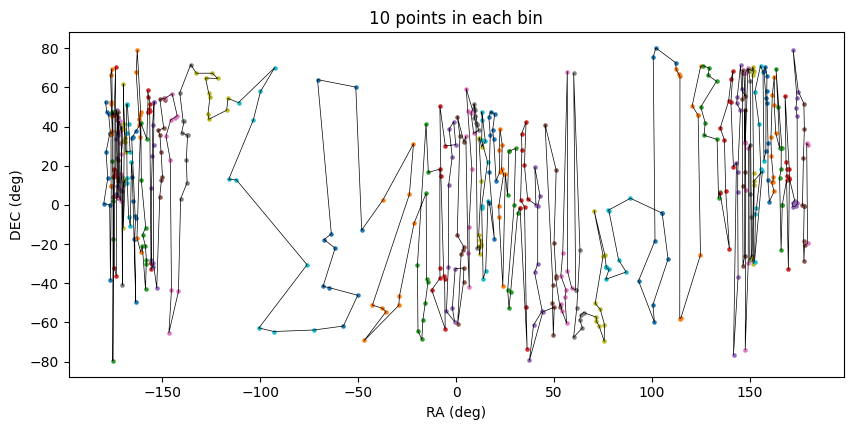

In [37]:
path = [point for bin_path in pointing_sequence for point in bin_path]
total_dist = 0
for i in range(len(path)-1):
    p1, p2 = path[i], path[i+1]
    total_dist += Haversine(p1, p2)

print(f'For {n} points in each bin')
print(f'Total angular distance traveled: {total_dist}°')

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect('equal')
px, py = zip(*path)
plt.plot(px, py, linewidth=0.5, color='k')

for bin_path in pointing_sequence:
    x, y = zip(*bin_path)
    plt.scatter(x, y, s=5)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title(f'{n} points in each bin')
# plt.title(f'{n} points in each bin, {int(total_dist)}° total angular distance traveled')
plt.show()

#### older version

In [ ]:
# Given a list of random targets (points)
NGS = np.genfromtxt('NGS_sample.csv', delimiter=',', skip_header=1, usecols=(0,1))
NGS[:,0] = np.vectorize(normalize_ra)(NGS[:,0])

# Sort the points by smallest to largest RA value
sortNGS = sorted(NGS, key=lambda point: point[0])

# Group every n points into a bin
""" Pick how many points in each bin """
n = 15
bins = [sortNGS[i:i+n] for i in range(0, len(sortNGS), n)]

pointing_sequence = []

# Iterate through the bins
for index, points in enumerate(bins):

    # For the first bin
    if index == 0:
        
        # Generate all possible permutations of the points, excluding the last point
        point_permutations = itertools.permutations(points[:-1])
        
        # Keep track of the minimum distance and the corresponding path
        min_distance = float('inf')
        min_path = None
        
        # Iterate through all permutations and calculate total distance for each
        for path in point_permutations:
            # Add the last point to the list of points
            full_path = path + (points[-1],)
            
            total_distance = 0
            for i in range(len(full_path) - 1):
                p1, p2 = full_path[i], full_path[i+1]
                total_distance += Haversine(p1, p2)
        
            # Check if the current path has a shorter total distance
            if total_distance < min_distance:
                min_distance = total_distance
                min_path = full_path

            # note down the last point of this bin
            last_point = min_path[-1]

    # For the rest of the bins
    else:
        # Determine the starting point for this bin
        start_index = StartingPoint(last_point, points)
        start_point = points.pop(start_index) # pop the starting point out of the bin

        # Generate all possible permutations of the points, excluding the last point
        point_permutations = itertools.permutations(points[:-1])
        
        # Keep track of the minimum distance and the corresponding path
        min_distance = float('inf')
        min_path = None
        
        # Iterate through all permutations and calculate total distance for each
        for path in point_permutations:
            # Add the first and last point to the list of points
            full_path = (start_point,) + path + (points[-1],)
            
            total_distance = 0
            for i in range(len(full_path) - 1):
                p1, p2 = full_path[i], full_path[i+1]
                total_distance += Haversine(p1, p2)
        
            # Check if the current path has a shorter total distance
            if total_distance < min_distance:
                min_distance = total_distance
                min_path = full_path

            # note down the last point of this bin
            last_point = min_path[-1]

    print(f'Bin {index+1}:')
    print(f"Minimum angular distance: {min_distance}")
    print("Optimal path:", min_path)
    print()

    # Store the optimal path of each bin
    pointing_sequence.append(min_path)

In [ ]:
import itertools
import math

# find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

""" just considering the first bin of n points """
# Given a list of n points
points = bins[0]

# Generate all possible permutations of the points, excluding the last point
point_permutations = itertools.permutations(points[:-1])

# Keep track of the minimum distance and the corresponding path
min_distance = float('inf')
min_path = None

# Iterate through all permutations and calculate total distance for each
for path in point_permutations:
    # Add the last point to the list of points
    full_path = path + (points[-1],)
    
    total_distance = 0
    for i in range(len(full_path) - 1):
        p1, p2 = full_path[i], full_path[i+1]
        total_distance += Haversine(p1, p2)

    # Check if the current path has a shorter total distance
    if total_distance < min_distance:
        min_distance = total_distance
        min_path = full_path

print(f"Minimum angular distance: {min_distance}")
print("Optimal path:", min_path)

In [ ]:
import matplotlib.pyplot as plt

x, y = zip(*min_path)
# optimal path
plt.plot(x, y, linestyle='-', marker='o', color='blue', label='Optimal Path')
plt.show()